October: This notebook extracts the realistic bathymetry of the domain.

In [2]:
import numpy as np
import netCDF4 as nc
import os
import scipy as sc, scipy.io
from pyproj import Proj, Geod, transform
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import colormap_ibcao
from scipy.interpolate import griddata
%matplotlib inline

# Get domain coordinates

In [2]:
filename = 'coords_mack06.nc'
coord_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/grid/tests_coordinates/'+filename)
lon_g = coord_file['nav_lon']
lat_g = coord_file['nav_lat']

def convert_corners(proj_from, proj_to, corner_lons, corner_lats):
    ''' Converts the coordinates of the domain corner points
    from the projection proj_from to the projection proj_to.
    The tranformed coordinates are returned.
    '''
    transformed_lons = []
    transformed_lats = []
    for i in np.arange(len(corner_lons)):
        transformed_x, transformed_y = transform(proj_from, proj_to, corner_lons[i], corner_lats[i])
        transformed_lons.append(transformed_x)
        transformed_lats.append(transformed_y)
    return transformed_lons, transformed_lats

# -----------------------------------------------------------------------------------------------
#lon_geogr = [lon[-1,0], lon[0,0], lon[0,-1], lon[-1,-1]]
#lat_geogr = [lat[-1,0], lat[0,0], lat[0,-1], lat[-1,-1]]

proj_geogr = Proj("+init=EPSG:4326") # Geographical coordinate system
proj_stere = Proj("+init=EPSG:3996") # IBCAO polar stereographic

#lon_stere0, lat_stere0 = convert_corners(proj_geogr, proj_stere, lon_geogr, lat_geogr)
#lon_stere = [round(float(x) / 500) * 500 for x in lon_stere0]
#lat_stere = [round(float(x) / 500) * 500 for x in lat_stere0]
#lonBR = lon_stere[0]; lonTR = lon_stere[1]; lonTL = lon_stere[2]; lonBL = lon_stere[3]
#latBR = lat_stere[0]; latTR = lat_stere[1]; latTL = lat_stere[2]; latBL = lat_stere[3]
#print(min(lon_stere0), lat_stere0)

# -----------------------------------------------------------------------------------------------
lon_s =  np.zeros_like(lon_g)
lat_s =  np.zeros_like(lat_g)
for i in np.arange(lon_g.shape[0]):
    lon_s[i,:], lat_s[i,:] = transform(proj_geogr, proj_stere, lon_g[i,:], lat_g[i,:])

# Get IBCAO bathymetry

In [3]:
bathy_file = scipy.io.netcdf_file('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/grid/IBCAO_V3_500m_RR.grd')
x = bathy_file.variables['x'][:]
y = bathy_file.variables['y'][:]
z = bathy_file.variables['z'][:]

In [9]:
xl=-1750e3; xr=-1050e3; yb=1300e3; yt=2000e3
xmin = np.where(x==xl)[0][0]; xmax = np.where(x==xr)[0][0]
ymin = np.where(y==yb)[0][0]; ymax = np.where(y==yt)[0][0]
xn = x[xmin:xmax]; yn = y[ymin:ymax]; zn = z[ymin:ymax, xmin:xmax]

# Stereographic map with corner points

# Specify domain area

# Mack

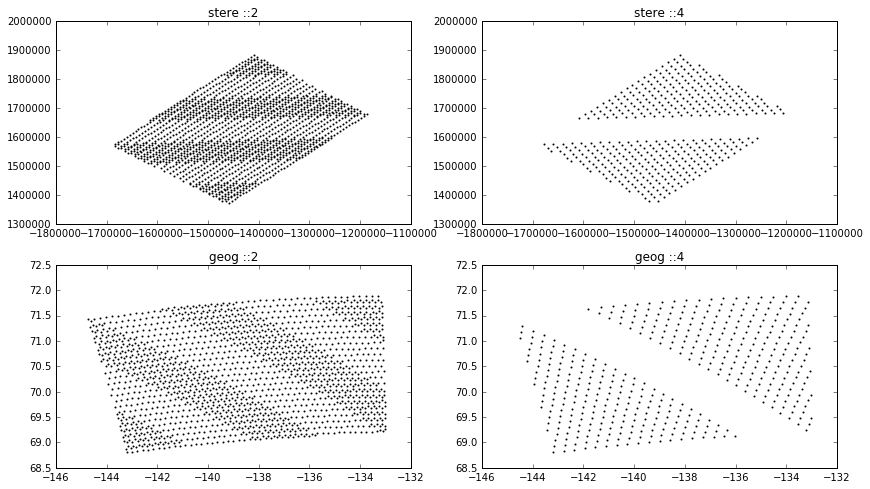

In [4]:
fig, ax = plt.subplots(2,2,figsize=(14,8))
for lon_this, lat_this, i, title in zip([lon_s, lon_g], [lat_s, lat_g], np.arange(2), ['stere', 'geog']):
    n = 2; ax[i,0].scatter(lon_this[::n,::n], lat_this[::n,::n], s = 1); ax[i,0].set_title(title+' ::'+str(n))
    n = 4; ax[i,1].scatter(lon_this[::n,::n], lat_this[::n,::n], s = 1); ax[i,1].set_title(title+' ::'+str(n))

In [5]:
X_full, Y_full = np.meshgrid(xn, yn) 
points = np.c_[np.ravel(X_full),np.ravel(Y_full)]
values = np.ravel(zn)
# ----------------------------------
z_new = griddata(points, values, (lon_s, lat_s), method='nearest')

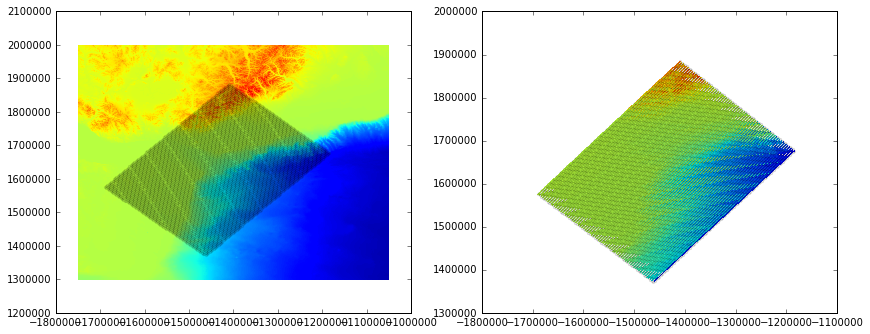

In [6]:
# there are no NaNs [test_this = np.isnan(z_new); test_this.max()]

fig, ax = plt.subplots(1,2,figsize=(14,5.4))
levels = [-4000, -3000, -2000, -1000, 0, 1000, 2000, 3000]
ax[0].pcolor(X_full, Y_full, zn, vmin = levels[0], vmax = levels[-1])
ax[0].scatter(lon_s, lat_s, c='k', s=5, alpha=0.1)

ax[1].pcolor(lon_s, lat_s, z_new, vmin = levels[0], vmax = levels[-1])
ax[1].scatter(lon_s, lat_s, c='k', s=5, alpha=0.1)

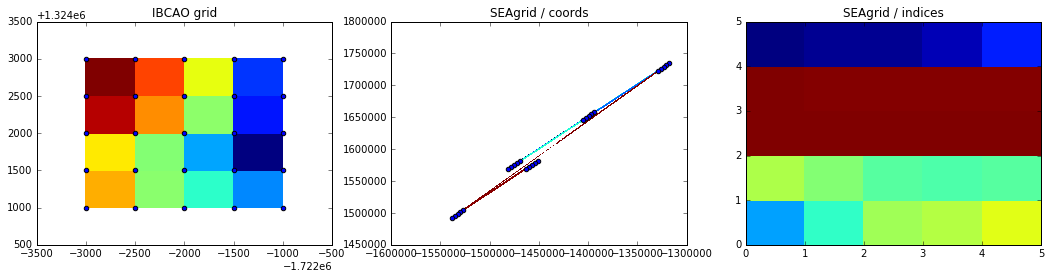

In [7]:
fig, ax = plt.subplots(1,3,figsize=(18,4))
for x_this, y_this, z_this, i in zip([X_full, lon_s], [Y_full, lat_s], [zn, z_new], np.arange(2)):
    ax[i].pcolor(x_this[50:55,50:55], y_this[50:55,50:55], z_this[50:55,50:55])
    ax[i].scatter(x_this[50:55,50:55], y_this[50:55,50:55])
ax[2].pcolor(z_new[50:55,50:55])
ax[0].set_title('IBCAO grid'); ax[1].set_title('SEAgrid / coords'); ax[2].set_title('SEAgrid / indices')

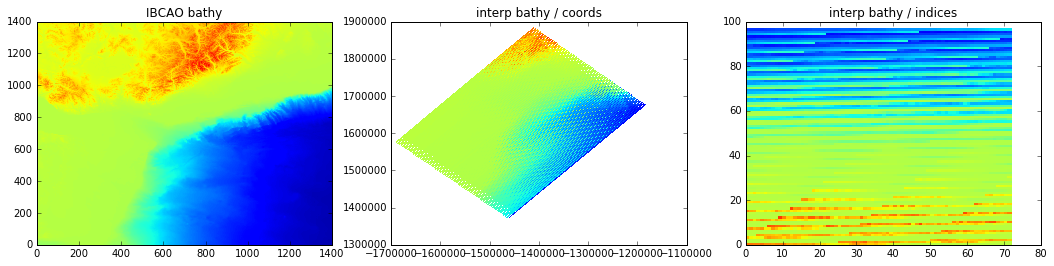

In [12]:
fig, ax = plt.subplots(1,3,figsize=(18,4))
for z_this, i in zip([zn, z_new], [0,2]):
    ax[i].pcolor(z_this, vmin = levels[0], vmax = levels[-1])
ax[1].pcolor(lon_s, lat_s, z_new, vmin = levels[0], vmax = levels[-1])
ax[0].set_title('IBCAO bathy'); ax[1].set_title('interp bathy / coords'); ax[2].set_title('interp bathy / indices')

In [12]:
xmin = 1080; xmax = 1085; ymin = 840; ymax = 845
xn2 = x[xmin:xmax]; yn2 = y[ymin:ymax]; zn2 = z[ymin:ymax, xmin:xmax]

# xn2 to X_full to points
# zn2 to values
# both do what I expect they would (no problems with ravel function)

X_full, Y_full = np.meshgrid(xn2, yn2) 
points = np.c_[np.ravel(X_full),np.ravel(Y_full)]
values = np.ravel(zn2)

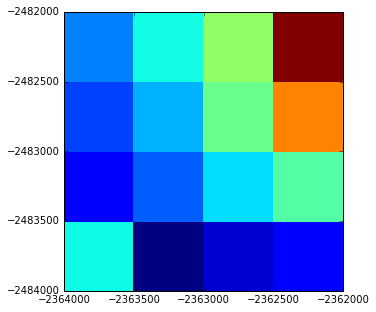

In [28]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.pcolor(xn2, yn2, zn2)
from matplotlib.ticker import ScalarFormatter
y_formatter = ScalarFormatter(useOffset=False)
ax.yaxis.set_major_formatter(y_formatter)
ax.xaxis.set_major_formatter(y_formatter)